The goal of this project is to develop a model that can classify sentiments from reviews of educational technology platforms. The data provided comes from a Google Play Store review of the Quipper app.

In [1]:
pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 2.5 MB/s 


In [16]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
import tensorflow as tf
import keras
from keras.layers import LSTM
from keras.preprocessing import text
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Upload Data**

In [3]:
quipper_df = pd.read_csv('https://raw.githubusercontent.com/Syamsyuriani/Data-Scrapping/main/Quipper-Data_labelled.csv')

In [4]:
quipper_df.columns

Index(['review', 'label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')

In [5]:
review = quipper_df.drop(columns=['Unnamed: 2', 'Unnamed: 3'])
review

,review,label
0,Apk Quipper sangat membantu dalam memahami pel...,-1
1,"Penjelasannya bagus, tutornya juga enak ngejel...",-1
2,"Tolong dong quipper, saya lagi ngerjain soal a...",-1
3,"Banyak bug. klo matematika, fisika, kimia ,Jaw...",-1
4,"Aplikasinya kurang menarik, pembahasan nya lam...",-1
...,...,...
6074,Gimana cara masukin soal?,-1
6075,Amit jangan donwlod nyesel,-1
6076,cari kode kelasnya dimanaaa..,-1
6077,Harus bayar paketnya,-1


In [6]:
# Remove duplicates
dt = review.drop_duplicates(subset=['review'], keep='last', inplace=False).reset_index()
df = dt.drop(['index'], axis=1)
df['label'] = df['label'].replace(-1,0)
df

,review,label
0,Apk Quipper sangat membantu dalam memahami pel...,0
1,"Penjelasannya bagus, tutornya juga enak ngejel...",0
2,"Tolong dong quipper, saya lagi ngerjain soal a...",0
3,"Banyak bug. klo matematika, fisika, kimia ,Jaw...",0
4,"Aplikasinya kurang menarik, pembahasan nya lam...",0
...,...,...
4682,Gimana cara masukin soal?,0
4683,Amit jangan donwlod nyesel,0
4684,cari kode kelasnya dimanaaa..,0
4685,Harus bayar paketnya,0


In [7]:
df['label'].value_counts()

0    2991
1    1696
Name: label, dtype: int64

Text(0.5, 1.0, 'Sentiment Class Distribution')

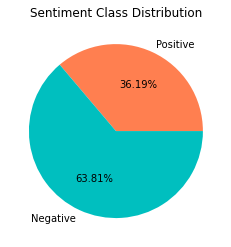

In [8]:
labels = ['Positive','Negative']
Category1 = [df['label'].value_counts()[1],df['label'].value_counts()[0]]
plt.pie(Category1, labels=labels, autopct='%1.2f%%', colors=['coral', 'c'])
plt.title('Sentiment Class Distribution')

# ***Pre-processing***

Before entering the model, all data sets including a collection of text and sentiment labels are processed. The text on the data must go through four phases of preprocessing, as follows.


1.   **Data Cleaning**: Capital letters are changed to lowercase, the website address, username, hashtag, punctuation, numbers, and extra spaces are removed, repeating words are separated by removing the dash, letters that are repeated more than twice are deleted into just two times, words with a single letter are deleted, remove stopwords, and the 'rt' is deleted.
2.   **Data tokenization** is the process of splitting words in sentences into word collections based on their spaces.
3.   **Data sequencing** is the numerical representation of each word based on the order in which it appears in the data, results in a vector representation.
4.   **Data Padding**: Adjusting the length of a representation vector to another sentence representation vector.

Furthermore, the data is divided into training data and test data. We divide the data into 80% training data and 20% test data.


In [9]:
# Data Cleaning
stop = list(stopwords.words('indonesian'))
stop = np.append(stopwords, "rt")
 
def clean_text(tweet):
 
    # Convert to lower case
    tweet = tweet.lower()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove punctuation
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove punctuation
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    #Clean number
    tweet = re.sub(r'[\d-]', '', tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #trim
    tweet = tweet.strip('\'"')
    # Clean per Words
    words = tweet.split()
    tokens=[]
    for ww in words:
        #split repeated word
        for w in re.split(r'[-/\s]\s*', ww):
            #replace two or more with two occurrences
            pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
            w = pattern.sub(r"\1\1", w)
            #strip punctuation
            w = w.strip('\'"?,.')
            #check if the word cosists of two or more alphabets
            val = re.search(r"^[a-zA-Z][a-zA-Z][a-zA-Z]*$", w)
            #add tokens
            if(w in stop or val is None):
                continue
            else:
                tokens.append(w.lower())
    
    tweet = " ".join(tokens)
    return tweet

In [10]:
df['review'] = df['review'].map(lambda x: clean_text(x))
df = df[df['review'].apply(lambda x: len(x.split()) >=1)]
df

,review,label
0,apk quipper sangat membantu dalam memahami pel...,0
1,penjelasannya bagus tutornya juga enak ngejela...,0
2,tolong dong quipper saya lagi ngerjain soal at...,0
3,banyak bug klo matematika fisika kimia jawaban...,0
4,aplikasinya kurang menarik pembahasan nya lama...,0
...,...,...
4682,gimana cara masukin soal,0
4683,amit jangan donwlod nyesel,0
4684,cari kode kelasnya dimanaa,0
4685,harus bayar paketnya,0


In [11]:
# Data Tokenization
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['review'])

In [12]:
# Data Sequencing and Padding
sequences = tokenizer.texts_to_sequences(df['review'])
x = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=80)
y = np.array((df['label']))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [14]:
seq_length = x.shape[1]
vocab_size = len(tokenizer.index_word) + 1

# **Model Building**

In this implementation, we use **epochs 5**, **batch sizes 32**, **Adam** learning method, and **binary cross-entropy loss**. To build the model, some parameters of each model need to be optimized. Moreover, the choices of parameter for models are shown in the following table.

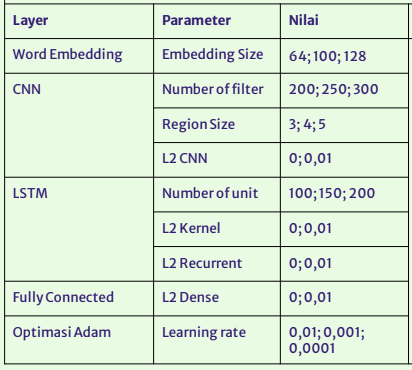

The values in the table are optimized using the Bayesian optimization technique with a max trial of 10.

In [17]:
def cnn_bilstm(hp):

    #Input layer
    inputs = keras.layers.Input(shape=(seq_length,))

    #Embedding
    embedding = keras.layers.Embedding(input_dim = vocab_size,
                                       output_dim = hp.Choice('embedding_size', values = [64, 100]))(inputs)

    #Convolution layer
    ngram_1 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_2 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_3 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_4 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)

    #Max Pooling layer
    ngram_1 = keras.layers.MaxPooling1D(pool_size=2)(ngram_1)
    ngram_2 = keras.layers.MaxPooling1D(pool_size=2)(ngram_2)
    ngram_3 = keras.layers.MaxPooling1D(pool_size=2)(ngram_3)
    ngram_4 = keras.layers.MaxPooling1D(pool_size=2)(ngram_4)
    merged = keras.layers.Concatenate(axis=1)([ngram_1, ngram_2, ngram_3, ngram_4])

    #BiLSTM layer
    bilstm = keras.layers.Bidirectional(LSTM(units = hp.Int('units',
                                                            min_value = 32,
                                                            max_value = 512,
                                                            step = 32),
                                             kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                                values = [0.0, 0.01])),
                                              recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                                    values = [0.0, 0.01]))))(merged)
    
    #Dropout layer
    lstm_out = keras.layers.Dropout(0.25)(bilstm)

    #Output layer
    output = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.0, 0.01])))(lstm_out)
    model = keras.models.Model(inputs=inputs, outputs=output)

    model.compile(optimizer = keras.optimizers.Adam(
                              hp.Choice('learning_rate', 
                                        values = [1e-2, 1e-3, 1e-4])),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

    return model

tuner = BayesianOptimization(cnn_bilstm,
                             objective = 'val_accuracy', 
                             max_trials = 10,
                             directory = 'Hasil',
                             project_name = 'Sentimen_CNN-BiLSTM')

tuner.search(x_train, y_train, batch_size=32, epochs = 5, validation_data = (x_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print('\nThe hyperparameter search is complete. \nembedding_size:', best_hps.get('embedding_size'),
      '\nfilters:', {best_hps.get('filters')},
      '\nkernel_size:', best_hps.get('kernel_size'),
      '\nkernel_cnn:', best_hps.get('kernel_cnn'),
      '\nunit:', best_hps.get('units'),
      '\nkernel_regularizer:', best_hps.get('kernel_regularizer'),
      '\nrec_regularizer:', best_hps.get('rec_regularizer'),
      '\nkernel_dense:', best_hps.get('kernel_dense'),
      '\nLearning rate:', best_hps.get('learning_rate'))

Trial 10 Complete [00h 03m 27s]
val_accuracy: 0.9036402702331543

Best val_accuracy So Far: 0.9036402702331543
Total elapsed time: 00h 25m 37s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
embedding_size: 64 
filters: {384} 
kernel_size: 5 
kernel_cnn: 0.0 
unit: 512 
kernel_regularizer: 0.0 
rec_regularizer: 0.01 
kernel_dense: 0.01 
Learning rate: 0.01


The model that has been created is illustrated in the graph below.

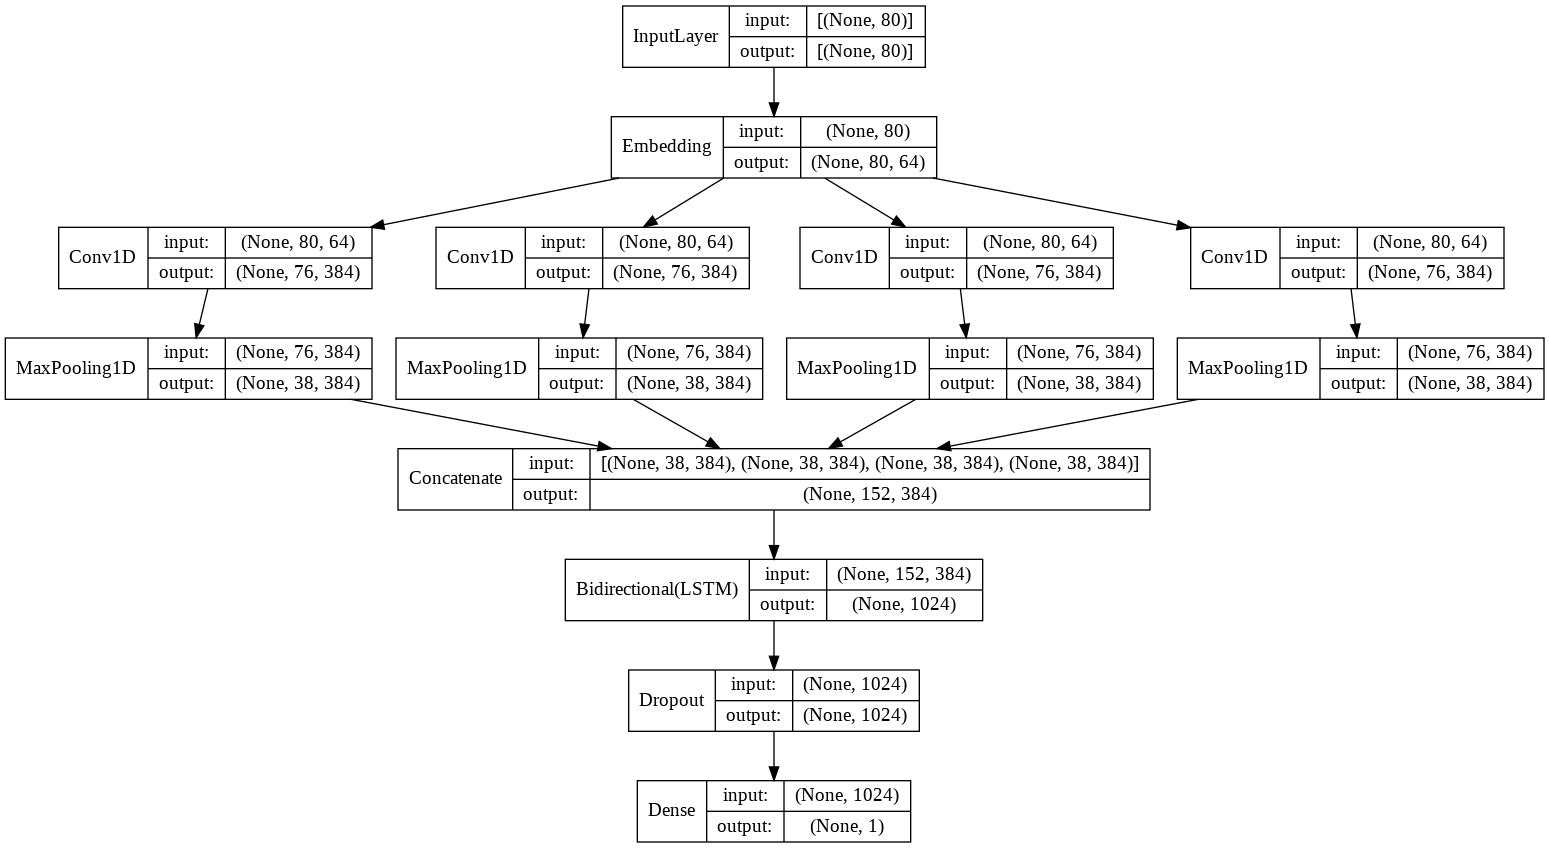

In [18]:
from tensorflow.keras.utils import plot_model

model = tuner.hypermodel.build(best_hps)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB')

The model is then retrained with the optimized parameters. We use epoch 150, batch size 32, and early stopping with patience 5, with validation loss as the value being monitored. This process produces a model with a fairly good accuracy, which is 86.62%.

In [36]:
from keras.callbacks import EarlyStopping

# Retrain model with the optimal hyperparameters
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, batch_size=32, epochs = 50, validation_data = (x_test, y_test), callbacks=[early_stop])

Epoch 1/50
117/117 [==============================] - 33s 256ms/step - loss: 0.0520 - accuracy: 0.9917 - val_loss: 0.4325 - val_accuracy: 0.8737
Epoch 2/50
117/117 [==============================] - 29s 246ms/step - loss: 0.0535 - accuracy: 0.9904 - val_loss: 0.4165 - val_accuracy: 0.8662
Epoch 3/50
117/117 [==============================] - 29s 247ms/step - loss: 0.0380 - accuracy: 0.9952 - val_loss: 0.4067 - val_accuracy: 0.8790
Epoch 4/50
117/117 [==============================] - 29s 248ms/step - loss: 0.0420 - accuracy: 0.9933 - val_loss: 0.4265 - val_accuracy: 0.8683
Epoch 5/50
117/117 [==============================] - 29s 248ms/step - loss: 0.0394 - accuracy: 0.9933 - val_loss: 0.4299 - val_accuracy: 0.8822
Epoch 6/50
117/117 [==============================] - 29s 247ms/step - loss: 0.0432 - accuracy: 0.9930 - val_loss: 0.4332 - val_accuracy: 0.8844
Epoch 7/50
117/117 [==============================] - 29s 248ms/step - loss: 0.0276 - accuracy: 0.9973 - val_loss: 0.4115 - val_ac

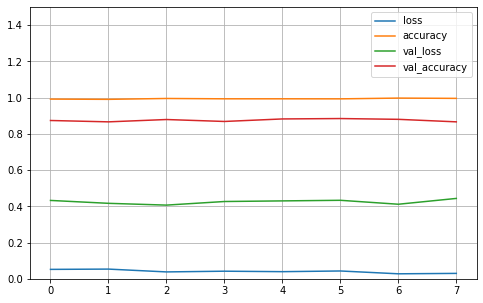

In [37]:
# Plot graph loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1.5)

plt.show()

In [38]:
## Model Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

30/30 [==============================] - 3s 87ms/step - loss: 0.4436 - accuracy: 0.8662
Test accuracy: 0.8661670088768005


In [39]:
## Save Model
model.save('Data/model_CNN-BiLSTM_sentiment.h5')

# **Classify new data**

We utilize the model to classify new data after we've built it. The results reveal that the model does a good job of classifying sentiment classes on new data.

In [40]:
new_data = pd.read_csv('https://raw.githubusercontent.com/Syamsyuriani/Data-Scrapping/main/Quipper-Data.csv')
new_data

,review
0,kalau bisa di perbarui lagi
1,KEREN!!!
2,"Kalo yang udah daftar terus di login pake facebook gampang,,, tapi kok quipper sekarang makin jelek"
3,Kode kelas tidak di temukan gimana nh min??? Dan untuk smk di tambah dong!!!!
4,"hai quipper video 😊 , saya ingin memberi masukan, lebih baik video yang sudah di unduh dan di si..."
...,...
93,Cacat quiper vidio gembel
94,Gak bisa buat SD ya? Hmmm...
95,Bikin belajar lebih mudah
96,Jawaban bener kok disalahin


In [41]:
# Load Model
model = keras.models.load_model('Data/model_CNN-BiLSTM_sentiment.h5')

In [42]:
# Data Tokenization and pad sequencing
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(new_data['review'])
seq = tokenizer.texts_to_sequences(new_data['review'])
x_pred = keras.preprocessing.sequence.pad_sequences(seq, maxlen=80)
y_pred = model.predict(x_pred)

treshold = 0.5
for i in range(y_pred.shape[0]):
  if y_pred[i] > treshold:
    y_pred[i] = 1
  else:
    y_pred[i] = -1

new_data['label'] = y_pred

In [43]:
pd.set_option("max_colwidth", 100)
new_data

,review,label
0,kalau bisa di perbarui lagi,1.0
1,KEREN!!!,1.0
2,"Kalo yang udah daftar terus di login pake facebook gampang,,, tapi kok quipper sekarang makin jelek",-1.0
3,Kode kelas tidak di temukan gimana nh min??? Dan untuk smk di tambah dong!!!!,-1.0
4,"hai quipper video 😊 , saya ingin memberi masukan, lebih baik video yang sudah di unduh dan di si...",-1.0
...,...,...
93,Cacat quiper vidio gembel,-1.0
94,Gak bisa buat SD ya? Hmmm...,-1.0
95,Bikin belajar lebih mudah,-1.0
96,Jawaban bener kok disalahin,-1.0
